In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

In [13]:
from PIL import Image
from IPython.display import display
import torch as th
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [32]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
has_cuda = device.type == 'cuda'

In [17]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100'
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [27]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27'  # Use 27 diffusion steps for very fast sampling

# Create and configure the upsampler model
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()

if has_cuda:
    model_up.convert_to_fp16()

# Move model to device and load state dict
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))

# Count total upsampler parameters efficiently
total_params = sum(p.numel() for p in model_up.parameters())
print('Total upsampler parameters:', total_params)


Total upsampler parameters: 398361286


In [28]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1) * 127.5).round().clamp(0, 255).to(th.uint8).cpu()

    # Reshape tensors and convert to numpy array
    reshaped = scaled.permute(0, 2, 3, 1).reshape(-1, scaled.size(2), 3)
    reshaped_np = reshaped.numpy()

    # Convert to uint8 and create PIL Image
    reshaped_uint8 = np.clip(reshaped_np, 0, 255).astype(np.uint8)
    pil_image = Image.fromarray(reshaped_uint8)

    # Display the image
    display(pil_image)


In [29]:
# Sampling parameters
prompt = "an oil painting of a corgi"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

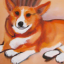

In [36]:
##############################
# Sample from the base model #
##############################

# Tokenize the prompt using the model tokenizer
tokens = model.tokenizer.encode(prompt)
# Generate tokens and mask for padding
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

# Create batch tensors for tokens and mask
tokens_batch = th.tensor(tokens, device=device).unsqueeze(0).repeat(batch_size, 1)
mask_batch = th.tensor(mask, dtype=th.bool, device=device).unsqueeze(0).repeat(batch_size, 1)

# Create empty tensors with appropriate sizes for unconditional guidance
uncond_tokens_batch = th.zeros_like(tokens_batch)
uncond_mask_batch = th.zeros_like(mask_batch, dtype=th.bool)

# Construct model keyword arguments for conditioning
model_kwargs = {
    'tokens': th.cat([tokens_batch, uncond_tokens_batch]),  # Concatenate conditional and unconditional tokens
    'mask': th.cat([mask_batch, uncond_mask_batch])  # Concatenate conditional and unconditional masks
}

# Define the model function for conditional sampling
def model_fn(x_t, ts, **kwargs):
    half = x_t[:len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model using diffusion process
with th.no_grad():
    model.del_cache()  # Clear model cache
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),  # Define image shape
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,  # Keyword arguments for the model function
        cond_fn=None,
    )[:batch_size]  # Select the specified batch size of samples
    model.del_cache()  # Clear model cache after sampling

# Display the output images
show_images(samples)


  0%|          | 0/27 [00:00<?, ?it/s]

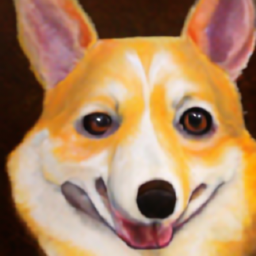

In [35]:
##############################
# Upsample the 64x64 samples #
##############################

# Tokenize prompt using the model tokenizer
tokens = model_up.tokenizer.encode(prompt)
# Generate tokens and mask for padding
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(tokens, options_up['text_ctx'])

# Create batch tensors for tokens and mask
tokens_batch = th.tensor(tokens, device=device).unsqueeze(0).repeat(batch_size, 1)
mask_batch = th.tensor(mask, dtype=th.bool, device=device).unsqueeze(0).repeat(batch_size, 1)

# Prepare low-resolution images for the model
low_res = ((samples + 1) * 127.5).round() / 127.5 - 1

# Construct model keyword arguments for upsampling
model_kwargs = {
    'low_res': low_res,  # Low-resolution images
    'tokens': tokens_batch,  # Tokens for conditioning
    'mask': mask_batch  # Mask for tokens
}

# Sample high-resolution images from the base model using diffusion
with th.no_grad():
    # Clear model cache
    model_up.del_cache()

    # Define the shape of the upsampled images
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])

    # Generate upsampled images using diffusion sampling
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,  # Keyword arguments for the model
        cond_fn=None,
    )[:batch_size]  # Select the specified batch size of samples
    model_up.del_cache()  # Clear model cache after sampling

# Display the output images
show_images(up_samples)
